In [ ]:
# default_exp basic_train
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# hide
from nbdev.showdoc import *
from nbdev.imports import *
from nbdev.export2html import *
if not os.environ.get("IN_TEST", None):
    assert IN_NOTEBOOK
    assert not IN_COLAB
    assert IN_IPYTHON

# Basic Train

> Contains basic Learners and Agents

In [ ]:
# export
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.torch_core import *
from fastai.layers import *
from fastrl.data_block import *
from dataclasses import asdict
import logging
import gym

from fastrl.basic_agents import *

In [ ]:
# hide
import gym
import sys


logging.basicConfig(format='[%(asctime)s] p%(process)s line:%(lineno)d %(levelname)s - %(message)s',
                    datefmt='%m-%d %H:%M:%S')
logging.getLogger('fastrl.data_block').setLevel('CRITICAL')
_logger=logging.getLogger(__name__)
_logger.setLevel('INFO')

## Learners

There is an important difference between `Learner`'s, `nn.Module`'s, and `Agent`'s. 

`Learners`:
- Contain `Agent`'s, `DataBunch`'s, `Callback`'s, and auxiliary objects such as `Experience`. 
- Function as orchestrators which handle the entire training cycle.
- Are not as portable / simple since they hold many different objects, some of which are not needed for simple execution.

`nn.Module`:
- Contain only `pytorch` related code.
- Function as the brain of any of these agents and are the objects to be optimized.
- Are highly portable, however for runtime usage are too "dumb" or simple to be practical. If by themselves, extra code needs to wrap them to handle environments.

`Agent` (`agent_core`):
- Ref `basic_agents`

In [ ]:
# export
class FloatifyCallback(LearnerCallback):
    def on_batch_begin(self,last_input,**kwargs):
        return {'last_input':[o.float() for o in last_input]}
    
class FakeRunCallback(LearnerCallback):
    def on_backward_begin(self,*args,**kwargs): return {'skip_bwd':True,'skip_validate':True}
    
def fake_loss(xb,yb): 
    print('returning loss')
    return tensor(0.5)

In [ ]:
# export
@dataclass
class AgentLearner(Learner):
    data:DataBunch
    model:nn.Module
    agent:BaseAgent=BaseAgent()
    training:bool=False
        
    def __post_init__(self):
        self.callback_fns=listify(self.callback_fns)+listify(self.data.callback_fns)+listify(FloatifyCallback)
        super(AgentLearner,self).__post_init__()
        self.data.learner=self
    
    def predict(self,s):
        return self.agent(s,None)

In [ ]:
data=ExperienceSourceDataBunch.from_env('CartPole-v1',display=False,firstlast=True,add_valid=False)
model=nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))
agent=DQNAgent(model=model)
learn=AgentLearner(data,model,agent=agent,callback_fns=[FakeRunCallback],loss_func=fake_loss)
learn.fit(10,lr=0.01,wd=1)

epoch,train_loss,valid_loss,time
0,0.500000,#na#,00:00
1,0.500000,#na#,00:00
2,0.500000,#na#,00:00
3,0.500000,#na#,00:00
4,0.500000,#na#,00:00
5,0.500000,#na#,00:00
6,0.500000,#na#,00:00
7,0.500000,#na#,00:00
8,0.500000,#na#,00:00
9,0.500000,#na#,00:00


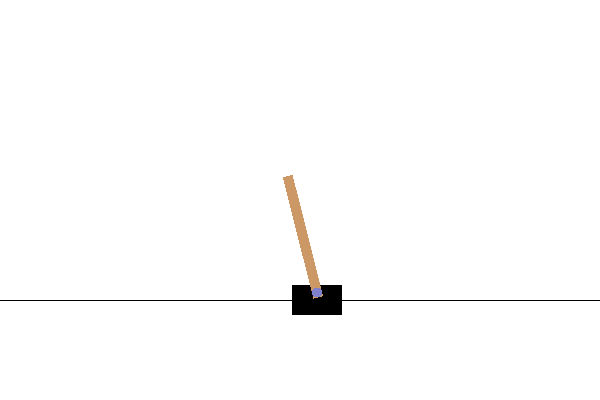

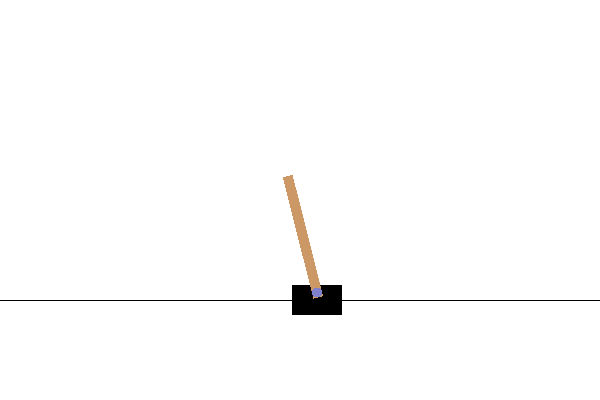

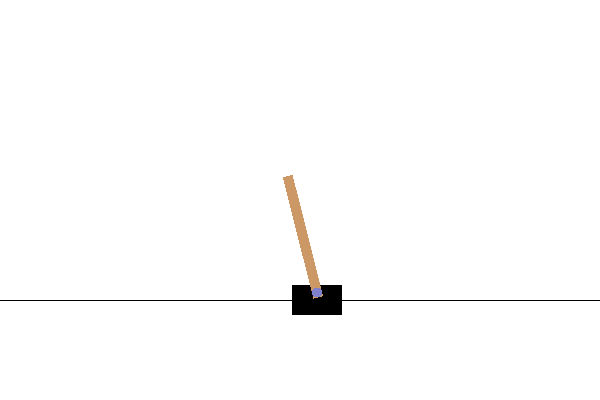

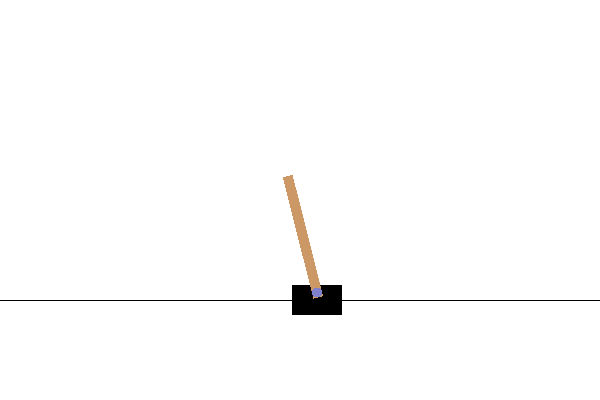

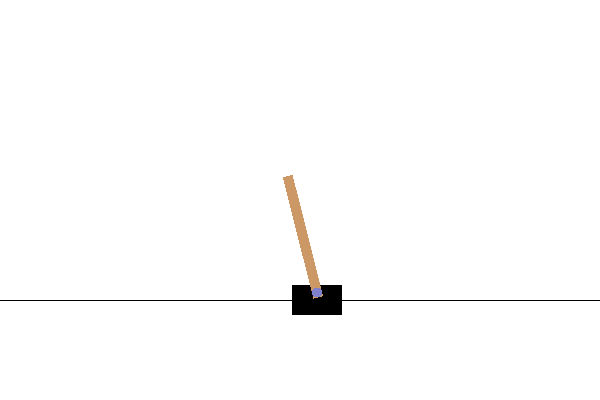

In [ ]:
data=ExperienceSourceDataBunch.from_env('CartPole-v1',n_envs=5,display=True,firstlast=False,add_valid=False)
model=nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))
agent=DQNAgent(model=model)
learn=AgentLearner(data,model,agent=agent,callback_fns=[FakeRunCallback],loss_func=fake_loss)
learn.fit(10,lr=0.01,wd=1)

In [ ]:
# try:
#     envs
#     ds=AsyncGradExperienceSourceDataset("CartPole-v1",n_envs=12,max_episode_step=50,steps=5)
#     dl=DataLoader(ds,batch_size=len(envs),num_workers=0)#len(envs))
#     learner=AgentLearner(DataBunch(dl,dl),nn.Sequential(nn.Linear(5,5),nn.ReLU(),nn.Linear(5,5)))
#     callback=AsyncGradExperienceSourceCallback(learner)
#     index=0
#     callback.on_epoch_begin()
#     for xb,yb in dl:
#         _logger.critical('xb: %s, yb: %s',torch.cat(xb).shape,yb[0].keys())
#         assert torch.cat(xb).shape[0]<=3
#         sys.stdout.flush()
#         index+=1
# finally:
#     callback.on_train_end()

data=AsyncExperienceSourceDataBunch.from_env('CartPole-v1',display=False,firstlast=True,add_valid=False)
model=nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))
agent=DQNAgent(model=model)
learn=AgentLearner(data,model,agent=agent,callback_fns=[FakeRunCallback],loss_func=fake_loss)
learn.fit(10,lr=0.01,wd=1)

epoch,train_loss,valid_loss,time


RuntimeError: expected a non-empty list of Tensors

In [ ]:
try:
    ds=AsyncDataExperienceSourceDataset("CartPole-v1",n_envs=12,max_episode_step=50,steps=5)
    dl=DataLoader(ds,batch_size=len(envs),num_workers=0)#len(envs))
    learner=AgentLearner(DataBunch(dl,dl),nn.Sequential(nn.Linear(5,5),nn.ReLU(),nn.Linear(5,5)))
    setattr(learner,'grad_fitter',data_fitter)
    callback=AsyncDataExperienceSourceCallback(learner)
    index=0
    callback.on_epoch_begin()
    for xb,yb in dl:
        _logger.critical('xb: %s, yb: %s',torch.cat(xb).shape,yb[0].keys())
        assert torch.cat(xb).shape[0]<=3
        sys.stdout.flush()
        index+=1
finally:
    callback.on_train_end()

In [ ]:
make_env = lambda: gym.make("CartPole-v1")
envs=[make_env() for _ in range(6)]
ds=ExperienceSourceDataset(envs,max_episode_step=50,steps=5)
ds=DatasetDisplayWrapper(ds,cols=3,rows=2,max_w=8000)
dl=DataLoader(ds,batch_size=len(envs),num_workers=0)#len(envs))
ds.learner=AgentLearner(DataBunch(dl,dl),nn.Sequential(nn.Linear(5,5),nn.ReLU(),nn.Linear(5,5)),
                     agent=DQNAgent(nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))))
for xb,yb in dl:
    assert torch.cat(xb).shape[0]<=5*6
    sys.stdout.flush()

In [ ]:
data=ExperienceSourceDataBunch.from_env('CartPole-v1',n_envs=5,display=False,add_valid=False)
data.train_dl.dataset.learn=AgentLearner(data,nn.Sequential(nn.Linear(5,5),nn.ReLU(),nn.Linear(5,5)),
                     agent=DQNAgent(nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))))
for xb,yb in data.train_dl:
    assert torch.cat(xb).shape[0]<=5*6
    sys.stdout.flush()

In [ ]:
data=ExperienceSourceDataBunch.from_env('CartPole-v1',n_envs=5,display=False)
data.train_dl.dataset.learn=AgentLearner(data,nn.Sequential(nn.Linear(5,5),nn.ReLU(),nn.Linear(5,5)),
                     agent=DQNAgent(nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))))
for xb,yb in data.train_dl:
    assert torch.cat(xb).shape[0]<=5*6
    sys.stdout.flush()

In [ ]:
data=ExperienceSourceDataBunch.from_env('CartPole-v1',n_envs=5,display=False,firstlast=True)
data.train_dl.dataset.learn=AgentLearner(data,nn.Sequential(nn.Linear(5,5),nn.ReLU(),nn.Linear(5,5)),
                     agent=DQNAgent(nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))))
for xb,yb in data.train_dl:
    assert torch.cat(xb).shape[0]<=5*6
    sys.stdout.flush()

In [ ]:
data=ExperienceSourceDataBunch.from_env('CartPole-v1',n_envs=5,display=True,firstlast=True,add_valid=False)
learn=AgentLearner(data,nn.Sequential(nn.Linear(5,5),nn.ReLU(),nn.Linear(5,5)),
                     agent=DQNAgent(nn.Sequential(nn.Linear(4,5),nn.ReLU(),nn.Linear(5,2))))
for xb,yb in data.train_dl:
    assert torch.cat(xb).shape[0]<=5*6
    sys.stdout.flush()

In [ ]:
# hide
from nbdev.export import *
notebook2script()
notebook2html(n_workers=0)